In [55]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm_notebook
sns.set_theme()

In [2]:
BATCH_SIZE = 100
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

val_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=BATCH_SIZE, shuffle=False)

In [4]:
batch, batch_labels = next(iter(val_loader))
batch.shape

torch.Size([100, 1, 28, 28])

In [5]:
def print_digits(imgs, real_imgs, epoch):
    fig, axes = plt.subplots(2, 8, figsize=(18,6))
    for i in range(8):
        axes[0,i].imshow(imgs[i].reshape(28, 28), cmap='gray')
        axes[0,i].grid(False)
        axes[0,i].set_title(f"Epoch: {epoch}, Encoded")
    for i in range(8):
        axes[1,i].imshow(real_imgs[i].reshape(28, 28), cmap='gray')
        axes[1,i].grid(False)
        axes[1,i].set_title(f"Epoch: {epoch}, Real")

In [38]:
def noise(x):
    return x + torch.randn_like(x) * 0.3

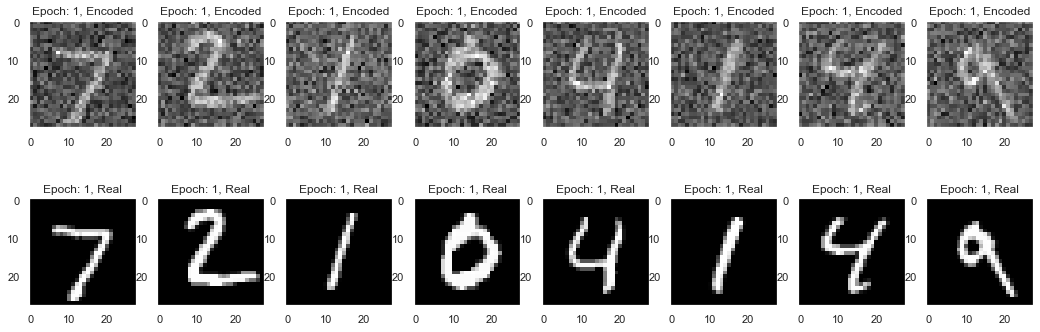

In [39]:
print_digits(noise(batch), batch, 1)

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # (N, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # (N, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7) # (N, 64, 1, 1)
        )
        
    def forward(self, x):
        return self.encoder(x)

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7), # (N, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # (N, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # (N, 1, 28, 28)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(x)

In [60]:
class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def _fit(self, train_loader, val_loader, batch_size=64):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.batch_size = batch_size
        
    def _train(self, epochs=10, optimizer=None, loss=None):
        self.epochs = epochs
        self.optim = optimizer
        self.criterion = loss
        self.loss = []
        self.val_loss = []
        self.outputs = []
        
        for i in range(self.epochs):
            loss_pe = 0
            val_loss_pe = 0
            loop = tqdm_notebook(enumerate(self.train_loader), total=len(self.train_loader), desc=f"Epoch: {i+1}, Training")
            for j, (X_train, _) in loop:
                X_train = X_train.to(device)
                X_train_noisy = noise(X_train)
                
                pred = self(X_train_noisy)
                loss = self.criterion(pred, X_train)
                
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
                
                loss_pe += loss.item()
                
                loop.set_postfix(average_loss=loss.item() * len(self.train_loader))
                
            self.eval()
            
            with torch.no_grad():
                val_loop = tqdm_notebook(enumerate(self.val_loader), total=len(self.val_loader), desc=f"Epoch: {i+1}, Evaluating")
                for j, (X_val, _) in val_loop:
                    X_val = X_val.to(device)
                    X_val_noisy = noise(X_val)
                    pred = self(X_val_noisy)
                    
                    if j == 0:
                        pred_val = pred.cpu().detach()
                    
                    val_loss = self.criterion(pred, X_val)
                    val_loss_pe += val_loss.item() * 6
                    
                    val_loop.set_postfix(average_val_loss=val_loss.item() * len(self.val_loader) * 6)
                    
            self.loss.append(loss_pe)
            self.val_loss.append(val_loss_pe)
            self.outputs.append(pred_val.cpu())
            
            print(f"Epoch: {i+1}, Loss: {loss_pe}, Val_loss: {val_loss_pe}")
            print("")
            
            self.train()
            
    def _plot_loss(self):
        plt.figure(figsize=(18,8))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        sns.lineplot(x=range(1, EPOCHS+1), y=self.loss, label='loss')
        sns.lineplot(x=range(1, EPOCHS+1), y=self.val_loss, label='val_loss')
        
    def _plot_outputs(self):
        for i, output in enumerate(self.outputs):
            print_digits(output, batch, i+1)

In [61]:
model = DAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

model._fit(train_loader, val_loader)
model._train(epochs=EPOCHS, optimizer=optimizer, loss=loss)

Epoch: 1, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 1, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Loss: 27.15745767392218, Val_loss: 8.853206567466259



Epoch: 2, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 2, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, Loss: 7.026906967163086, Val_loss: 5.635794480331242



Epoch: 3, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 3, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3, Loss: 5.271444079466164, Val_loss: 4.761099765077233



Epoch: 4, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 4, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4, Loss: 4.6387161505408585, Val_loss: 4.32895446382463



Epoch: 5, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 5, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5, Loss: 4.2793452283367515, Val_loss: 4.072579527273774



Epoch: 6, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 6, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6, Loss: 4.054626110941172, Val_loss: 3.9045543428510427



Epoch: 7, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 7, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7, Loss: 3.8977809036150575, Val_loss: 3.7868041042238474



Epoch: 8, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 8, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8, Loss: 3.785162718500942, Val_loss: 3.6792898010462523



Epoch: 9, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 9, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, Loss: 3.691041762009263, Val_loss: 3.6141357282176614



Epoch: 10, Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 10, Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, Loss: 3.614842079114169, Val_loss: 3.5519216638058424



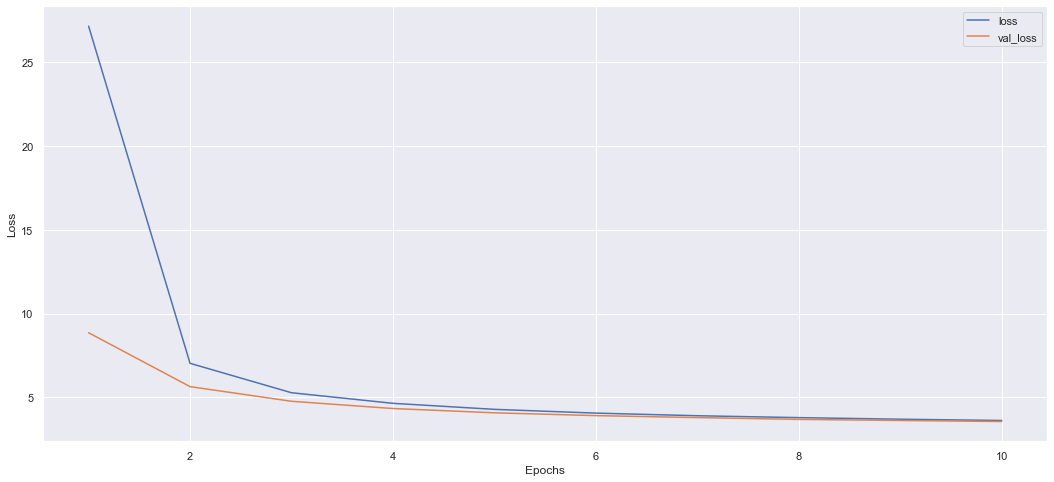

In [62]:
model._plot_loss()

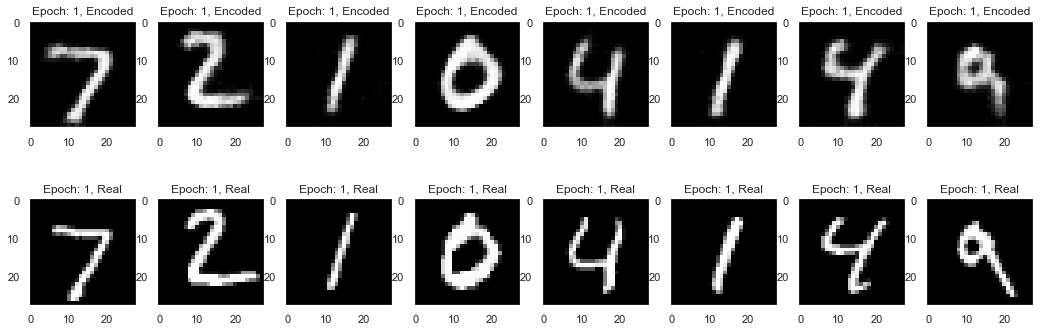

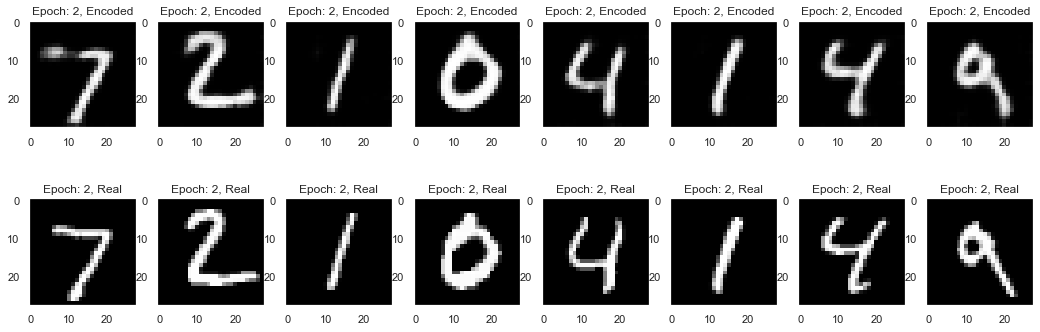

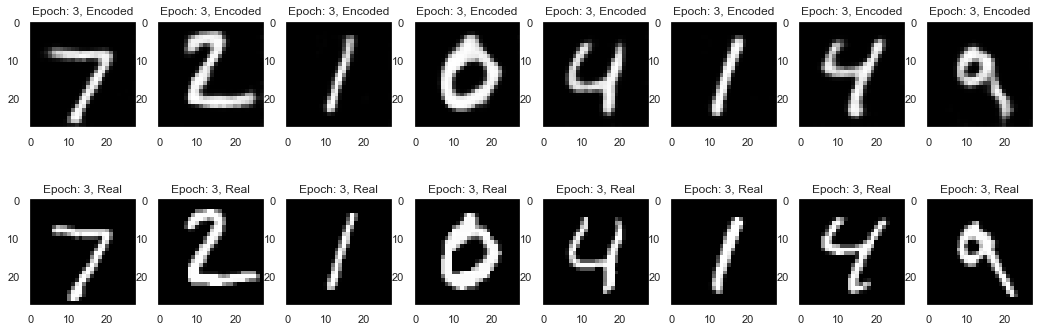

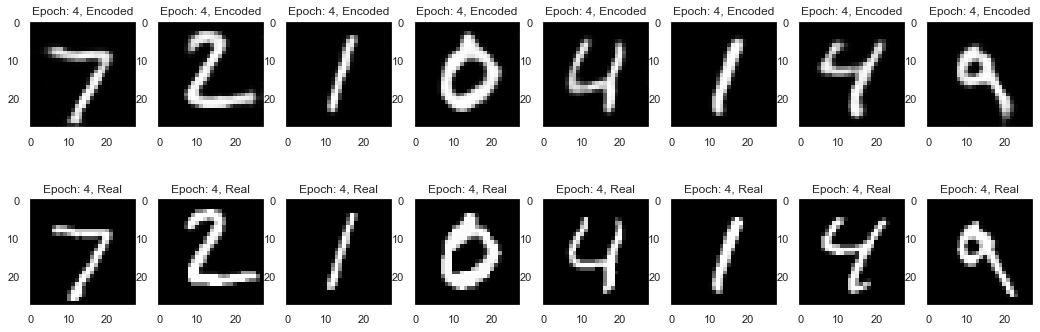

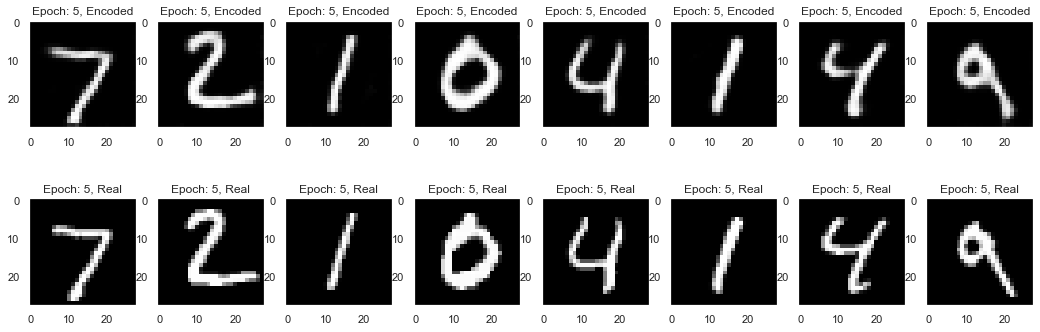

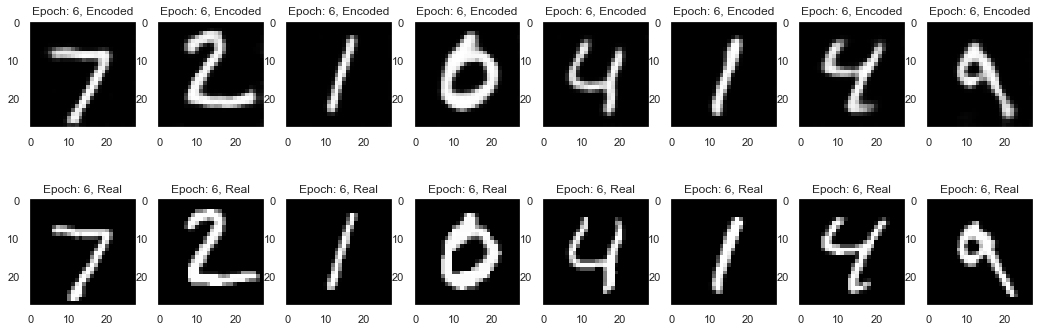

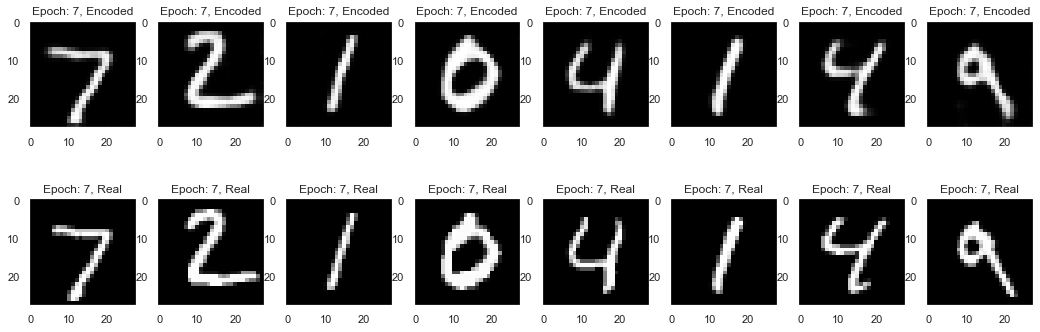

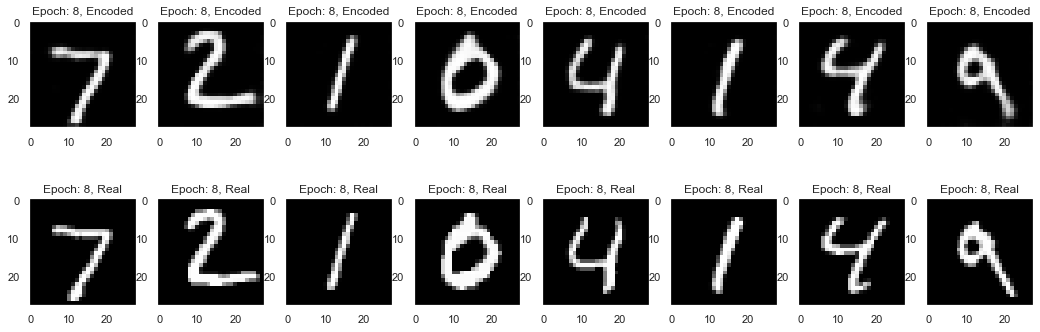

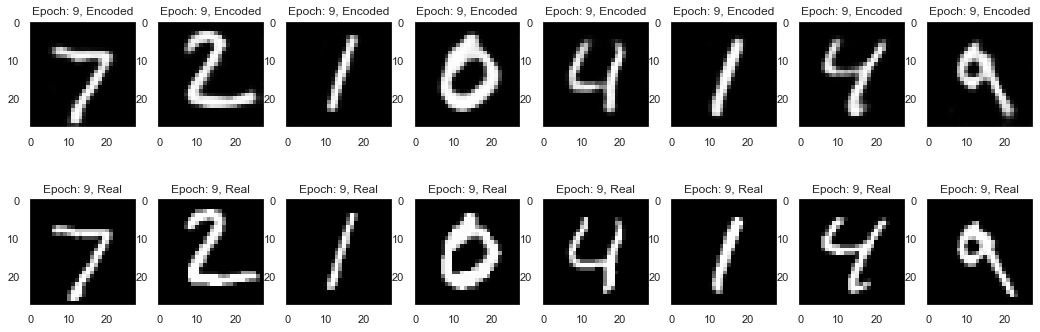

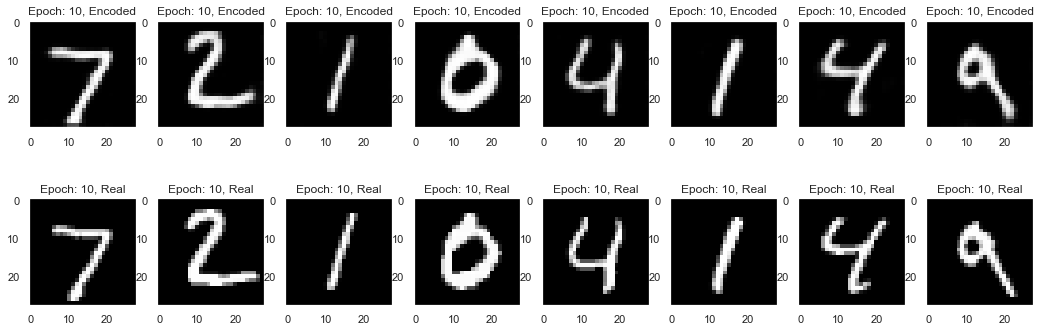

In [63]:
model._plot_outputs()